# Unique Eddy Profile Analysis

This notebook demonstrates the process of analyzing oceanographic profiles associated with a unique eddy event. The workflow includes data loading, preprocessing, matching with background climatology, and visualization of anomalies in an eddy composite. The goal is to provide a clear, reproducible example of the eddy profile matching methodology.

## Data Sources

- **Matched Profiles:** Profiles matched to eddy events, stored in NetCDF format.
- **Background Climatology:** Reference background profiles from WOA/WOD datasets.

The data is organized in the `data/external/Matched/` and `data/external/Background/` directories.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.lines import Line2D
import gsw
from tqdm import tqdm
from datetime import datetime
import icechunk
from xhistogram.xarray import histogram

## Visualization and Analysis

We visualize the matched profiles, background profiles, and computed anomalies to interpret the physical and biogeochemical characteristics of the eddy.

## Data Loading and Preprocessing

In this section, we load the matched and background profiles, perform any necessary preprocessing, and prepare the data for analysis.

In [ ]:
keep_variables = ["eddy_rotation","eddy_longitude","eddy_latitude", "eddy_track", "eddy_speed_radius", "eddy_amplitude"]


domain = "matched"
dataset = "pfl"
variables = ["Temperature", "Salinity"]
eddy_track_id = 578618

ds_list = []
for variable in variables:
    storage = icechunk.s3_storage(
        bucket="iuryt-shared",
        prefix=f"icechunk/ocean/vortex-profiles/{domain.title()}/{dataset}_{variable}",
        region="us-west-2",
    )

    repo = icechunk.Repository.open(storage)
    session = repo.readonly_session("main")

    ds = xr.open_zarr(session.store, consolidated=False)

    ind = np.argwhere((ds.eddy_track==eddy_track_id).values).flatten()
    ds_list.append(ds.isel(casts=ind)[keep_variables+[variable.lower()]].load())
ds = xr.merge(ds_list)

Estimate and include on `ds` the absolute salinity and conservative temperature using the `gsw` library.

In [4]:
p = gsw.p_from_z(-ds.z, lat=ds.lat)
ds["absolute_salinity"] = gsw.SA_from_SP(ds.salinity, ds.z, ds.lon, ds.lat)
ds["conservative_temperature"] = gsw.CT_from_t(ds.absolute_salinity, ds.temperature, p)

Make a simple plot of the positions of the profiles and the eddy center.

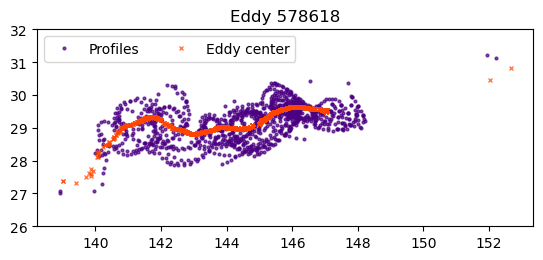

In [25]:
fig, ax = plt.subplots()
ax.plot(ds.lon, ds.lat, ".", color="indigo", markersize=4, alpha=0.7, label="Profiles")
ax.plot(ds.eddy_longitude, ds.eddy_latitude, "x", color="orangered", markersize=3, alpha=0.7, label="Eddy center")
ax.axis("scaled")
ax.set(ylim=[26, 32], title=f"Eddy {eddy_track_id}")
ax.legend(ncols=2)

## Estimating eddy anomalies

Profiles are matched to background climatology based on spatial and temporal (month) proximity. This allows for the calculation of anomalies and the assessment of eddy anomalies.

In [ ]:
base_url = "https://www.ncei.noaa.gov/thredds-ocean/dodsC/ncei/woa"
params = ["temperature", "salinity"]

lonmin, lonmax = ds.lon.min()-2, ds.lon.max()+2
latmin, latmax = ds.lat.min()-2, ds.lat.max()+2

datasets = []
months = np.arange(1, 13)

for param in tqdm(params):
    urls = [f"{base_url}/{param}/decav/1.00/woa18_decav_{param[0]}{m:02.0f}_01.nc" for m in months]
    woa = xr.open_mfdataset(urls, decode_times=False)

    woa = woa.rename(time="month").assign_coords(month=months)  
    datasets.append(woa)

woa = xr.merge(datasets)
woa = woa.rename(depth="z")
woa = woa.sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax))[["s_an", "t_an"]].load()


p = gsw.p_from_z(-woa.z, lat=woa.lat)
woa["clim_absolute_salinity"] = gsw.SA_from_SP(woa.s_an, woa.z, woa.lon, woa.lat)
woa["clim_conservative_temperature"] = gsw.CT_from_t(woa.clim_absolute_salinity, woa.t_an, p)


clim = woa.interp(lon=ds.lon, lat=ds.lat, month=ds.time.dt.month, z=ds.z)
ds["anom_absolute_salinity"] = ds.absolute_salinity-clim.clim_absolute_salinity
ds["anom_conservative_temperature"] = ds.conservative_temperature-clim.clim_conservative_temperature

## Eddy composite

We create a composite of the anomalies within the eddy as a function of the distance from the eddy center and depth. This composite helps to visualize the typical structure of the eddy and its impact on the surrounding water column.

In [31]:
cast_longitude = ds.lon.values
cast_latitude = ds.lat.values
eddy_longitude = ds.isel(levels=0).eddy_longitude.values
eddy_latitude = ds.isel(levels=0).eddy_latitude.values
radius = ds.isel(levels=0).eddy_speed_radius.values

In [32]:
longitude = np.vstack([cast_longitude, eddy_longitude])
latitude = np.vstack([cast_latitude, eddy_latitude])
distance = gsw.distance(longitude, latitude, axis=0).flatten()/radius
ds["distance"] = (("casts"), distance)

In [33]:
bins = [np.arange(0,1000,10), np.arange(0,1.5,0.15)]
H = histogram(ds.z, ds.distance, bins=bins)
temperature = histogram(ds.z, ds.distance, bins=bins, weights=ds.anom_conservative_temperature.fillna(0))/H
salinity = histogram(ds.z, ds.distance, bins=bins, weights=ds.anom_absolute_salinity.fillna(0))/H

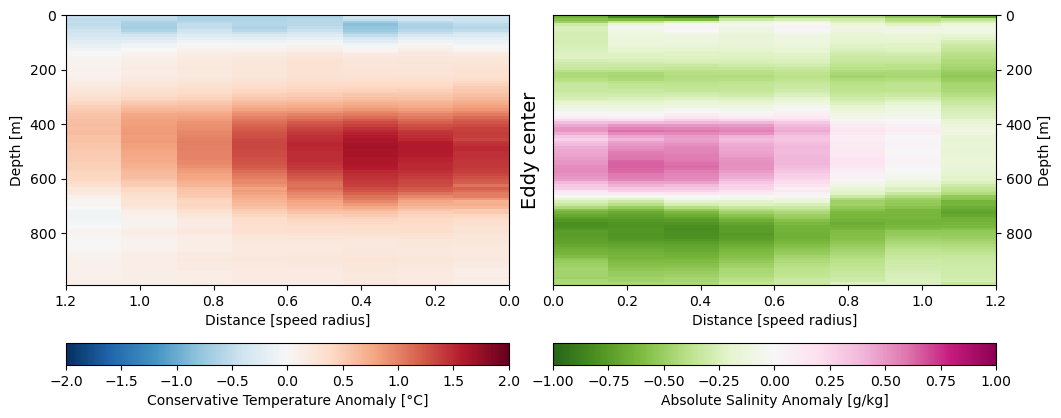

In [44]:
kw = dict(
    temperature=dict(vmin=-2, vmax=2, cmap="RdBu_r", xlim=[1.2, 0], yincrease=False, cbar_kwargs={"label": "Conservative Temperature Anomaly [°C]", "orientation": "horizontal", "pad": 0.15}),
    salinity=dict(vmin=-1, vmax=1, cmap="PiYG_r", xlim=[0, 1.2], yincrease=False, cbar_kwargs={"label": "Absolute Salinity Anomaly [g/kg]", "orientation": "horizontal", "pad": 0.15})
)
fig,ax = plt.subplots(1,2, figsize=(12,5))
fig.subplots_adjust(wspace=0.1)
temperature.plot(ax=ax[0], **kw["temperature"])
(10*salinity).plot(ax=ax[1], **kw["salinity"])
ax[0].set(xlabel="Distance [speed radius]", ylabel="Depth [m]")
ax[1].set(xlabel="Distance [speed radius]", ylabel="Depth [m]")
ax[1].text(-0.05, 0.5, "Eddy center", rotation=90, va="center", ha="center", transform=ax[1].transAxes, fontsize=14)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()

## Conclusion and Next Steps

This notebook provided an end-to-end example of unique eddy profile analysis, from data loading to anomaly visualization. For further analysis, consider:
- Comparing multiple eddy events
- Incorporating additional variables (e.g., nutrients, oxygen)
- Applying machine learning for pattern recognition

Feel free to adapt this workflow for your own oceanographic studies.